#### COMPANION WORKBOOK

# Model Evaluation

To make the most out of this program, we strongly recommend you to:
1. First practice writing and implementing all of the code from Coding Section of the online module.
2. Then, freely experiment with and explore any interesting or confusing concepts. Simply insert new code cells and then use the help of Google and official documentation.
3. Finally, tackle all of the exercises at the end. They will help you tie everything together and **learn in context.**

#### <span style="color:#555">MODULE CODE SANDBOX</span>

Use this space to practice writing and implementing all of the code from Coding Section of the online module. Insert new code cells as needed, and feel free to write notes to yourself in Markdown.

#### Important Note: You're now in the driver's seat!

For this project, we're going to leave the standard model training steps to you. But don't worry, we've provided a **guided exercise** for each of the major steps. It's imperative that you finish those exercises, and you can find them below.

## I. Prep Work

#### First, let's import the libraries, helper functions, and classes we'll need.
* Again, we'll have you import the right libraries for this module. We've included comments below to guide you.
* If you forget one, you can always add it here later and re-run this code block.
* When in doubt regarding which Scikit-Learn submodule something belongs to, this <a href="http://scikit-learn.org/stable/modules/classes.html" target="_blank">documentation page</a> is a great resource.
* Check the answer key if needed.

In [179]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Seaborn for easier visualization
import seaborn as sns
sns.set_style('darkgrid')

# Pickle for saving model files
import pickle

# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Import RandomForestClassifier and GradientBoostingClassifer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Function for splitting training and test set
from sklearn.model_selection import train_test_split

# Function for creating model pipelines
from sklearn.pipeline import make_pipeline

# StandardScaler
from sklearn.preprocessing import StandardScaler

# GridSearchCV
from sklearn.model_selection import GridSearchCV


#### Next, let's read in the analytical base table you saved at the end of Module 2.

In [180]:
# Load analytical base table from Module 2
df = pd.read_csv('abt.csv')
df.head()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,last_eval_is_missing,underperformer,unhappy,...,department_finance,department_management,department_marketing,department_procurement,department_product,department_sales,department_support,salary_high,salary_low,salary_medium
0,221,0.0,0.932868,4,0.0,0.829896,5.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,232,0.0,0.000000,3,0.0,0.834544,2.0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,184,0.0,0.788830,3,0.0,0.834988,3.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,206,0.0,0.575688,4,0.0,0.424764,2.0,0,1,0,...,0,0,0,0,0,1,0,0,1,0
4,249,0.0,0.845217,3,0.0,0.779043,3.0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In order to illustrate the new concepts presented in this module, we're going to return to the noisy conditional simulated dataset... but this time, we're going to add a twist.

We generate 1000 observations, tweak the noise variables, then change the threshold for the target variable to be 0.97 instead of 0.5. 

In [181]:
X = np.linspace(0, 1, 1000)

np.random.seed(555)
noise = np.random.uniform(-0.02, 0.02, 1000)

y = ((X + noise)>0.97).astype(int)

X = X.reshape(-1, 1)

In [182]:
print(y.mean())

0.029


This means only about 3% of the observations should be in the positive class (y = 1)

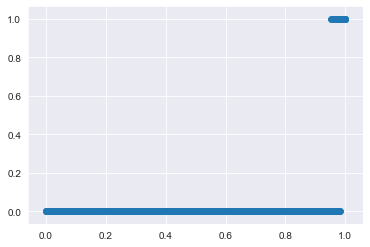

In [183]:
plt.scatter(X, y)
plt.show()

## II. Accuracy vs. Imbalanced Classes

Straight accuracy is not always the best way to evaluate a classification model. Specifically, it's not a good metric when evaluating **imbalanced classes** in your target variable.

Let's say only 3% of our observations belong to the positive class, and the other 97% were the negative class (0). 

If we were to make a brain-dead simple model that will predict 0 100% of the time, we would have already achieved a model accuracy of 97%, **simply because 97% of our observations are 0**.

Hence we need **a more advanced metric to handle imbalanced classes.**

In [184]:
pred_dumb = [0] * len(y)

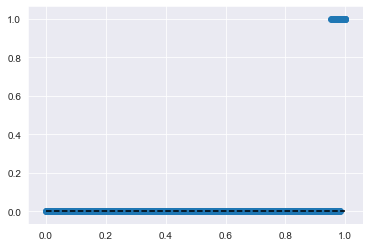

In [185]:
plt.scatter(X, y)
plt.plot(X, pred_dumb, 'k--')
plt.show()

Let's compare it to a **L2-regularized logistic regression**, using the hyperparameter setting C=10

In [186]:
clf = LogisticRegression(C=10, random_state=123)
clf.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

**Get both the predicted class labels and their corresponding probabilities.**

In [187]:
# predicted classes
pred_class = clf.predict(X)

# probabilities of predicted classes
pred_proba = clf.predict_proba(X)
pred = [p[1] for p in pred_proba]

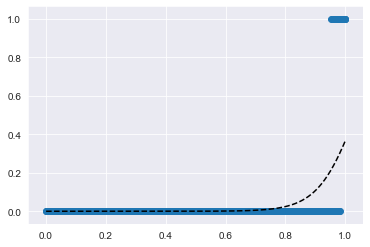

In [188]:
plt.scatter(X, y)
plt.plot(X, pred, 'k--')
plt.show()

In [189]:
from sklearn.metrics import accuracy_score

print("Dumb model accuracy: ", accuracy_score(y, pred_dumb))
print("Logistic Reg accuracy: ", accuracy_score(y, pred_class))

Dumb model accuracy:  0.971
Logistic Reg accuracy:  0.971


**As you can see, they have the same accuracies!** Why not just label all our predictions as 0 and call it a day?

## III. True Positive Rate vs. False Positive Rate

For binary classifications, there are 4 possible outcomes:
1. **True positive** : predict 1 when actual class is 1
2. **False positive** : predict 1 when actual class is 0
3. **True negative** : predict 0 when actual class is 0
4. **False negative**: predict 0 when actual class is 1

In [190]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y, pred_class))

[[971   0]
 [ 29   0]]


- First column indicates observations that were predicted as 0 (negative class)

- Second column indicates observations that were predicted as 1 (our positive class)

- First row indicates observations that are actually 0 (negative class).

- Second row indicates observations that are actually 1 (positive class).

Hence, 

- 971 were true negatives
- 29 were false negatives
- 0 were false positives (top right)
- 0 were true positives (bottom right)

Using these info, we can separately evaluate the performance for both the positive and negative class. 

Specifically, the confusion matrix allows us to calculate two metrics:
- **True positive rate (TPR), also known as recall**, which is TP / (TP + FN). This is the ability of the model to **correctly** predict on the positive class (2nd row of the confusion matrix). Of all the predictions on the positive class, the proportion of the correct predictions.

- **False positive rate (FPR)**, which is FP / (FP + TN). In proportion of all the predictions on the negative class (0), the proportion of those incorrectly predicted as positives.

**Obviously, we want TPR to be as high as possible and FPR to be as low as possible**

In [191]:
# Reduce threshold of LogisticRegression model to allow for more positive predictions. By default, threshold is set to 0.5.
# Hence, if probability in predicting the positive class is 0.28, the model will classify the observation as 0 (negative class).

# to reduce threshold
pred_class_v2 = (np.array(pred) > 0.25).astype(int)

In [192]:
print(confusion_matrix(y, pred_class_v2))

[[962   9]
 [  3  26]]


## IV. Area Under ROC Curve (AUROC)

**Area Under ROC Curve (AUROC) is equivalent to the probability that a randomly chosen positive class observation ranks higher (has a higher predicted probability) than a randomly chosen negative class observation.**

That is, if you grabbed 2 observations, one being the positive class and the other the negative class, what's the likelihood your model can distinguish between the 2?

**AUROC is the cure for imbalanced classes.**

In [193]:
from sklearn.metrics import roc_curve, roc_auc_score

In [194]:
# calculate ROC curve from y and pred
fpr, tpr, thresholds = roc_curve(y, pred)

In [195]:
pd.DataFrame({'FPR': fpr, 'TPR' : tpr, 'Thresholds' : thresholds})

,FPR,TPR,Thresholds
0,0.000000,0.000000,1.363981e+00
1,0.000000,0.034483,3.639811e-01
2,0.000000,0.586207,3.080237e-01
3,0.001030,0.586207,3.046868e-01
4,0.001030,0.724138,2.915454e-01
5,0.003090,0.724138,2.851012e-01
6,0.003090,0.758621,2.819115e-01
7,0.007209,0.758621,2.693718e-01
8,0.007209,0.793103,2.662925e-01
9,0.008239,0.793103,2.632357e-01


As the threshold decreases, both FPR and TPR increases

#### Plotting the ROC curve

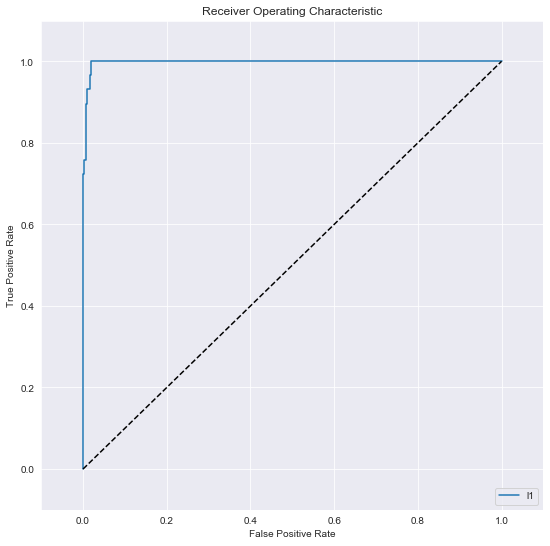

In [196]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We want the blue line to sit as high up as possible from the dotted line.

#### Area under ROC

- the area under the blue line
- maximum AUROC possible is 1
- AUROC for a completely random model is 0.5

In [197]:
roc_auc_score(y, pred)

0.9971589900209524

This means that our L1-regularized logistic regression model has a 99.7% chance of distinguishing between a positive observation and a negative one.

In [198]:
roc_auc_score(y, pred_dumb)

0.5

This AUROC of 0.5 makes complete sense if you think about it. Since we're ALWAYS predicting 0 with the "dumb" model, it means that if you randomly choose a positive and a negative class observation, the "dumb" model predicts the exact same prediction for both of them.

#### <span style="color:#555">EXERCISES</span>

Complete each of the following exercises.

## <span style="color:RoyalBlue">Exercise 4.1 - Split Your Dataset</span>

Let's start by splitting our data into separate training and test sets. Remember, your data is a **limited resource**.
* You can spend some of it to train your model.
* You can spend some of it to test, or evaluate your model.
* But you can't use the same data for both!

Having a true "unseen" test dataset helps you detect overfit models and ultimately select the best model.

#### A.) First, separate the dataframe into separate objects for the target variable, <code style="color:steelblue">y</code>, and the input features, <code style="color:steelblue">X</code>.

In [199]:
df['status'] = df['status_Left'].apply(lambda x: 1 if x==1 else 0)
df.shape

(14068, 28)

In [200]:
df = df.drop(['status_Left', 'status_Employed'], axis=1)
df.shape

(14068, 26)

In [201]:
df.status.unique()

array([1, 0], dtype=int64)

In [202]:
y = df['status']
X = df.drop('status', axis=1)

Now you can pass <code style="color:steelblue">X</code> and <code style="color:steelblue">y</code> to the <code style="color:steelblue">train_test_split()</code> function. If you forgot to import this function, you can go back and import it. When in doubt, this <a href="http://scikit-learn.org/stable/modules/classes.html" target="_blank">documentation page</a> is a great resource. Simply search (Windows Control + F or Mac Command + F) for the function you want. The prefix before the function name is where it's located. For example:

<pre style="color:steelblue">
    from sklearn<strong>.model_selection</strong> import <strong>train_test_split</strong>
</pre>

#### B.) After you've imported the function, split <code style="color:steelblue">X</code> and <code style="color:steelblue">y</code> into training and test sets.
* Pass in the argument <code style="color:steelblue">test_size=<span style="color:crimson">0.2</span></code> to set aside 20% of our observations for the test set.
* Pass in <code style="color:steelblue">random_state=<span style="color:crimson">1234</span></code> to set the random state for replicable results.
* **Important:** Also pass in the argument <code style="color:steelblue">stratify=<span style="color:crimson">abt.status</span></code> in order to make sure the target variable's classes are balanced in each subset of data! This is **stratified random sampling**.
* Then, print the number of observations in each subset to check that it was done correctly.

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=df.status)
print(len(X_train), len(X_test), len(y_train), len(y_test))

11254 2814 11254 2814


<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
11254 2814 11254 2814
</pre>

## <span style="color:RoyalBlue">Exercise 4.2 - Build Model Pipelines</span>

Next, let's set up preprocessing pipelines for each of our algorithms. Remember, it's almost always useful to **standardize** our features, or bring them to the same scale.

#### A.) First, make sure you've imported 2 important tools for this step.
* <code style="color:steelblue">make_pipeline()</code> for building the pipeline.
* <code style="color:steelblue">StandardScaler()</code> for standardization.
* Again, this <a href="http://scikit-learn.org/stable/modules/classes.html" target="_blank">documentation page</a> is a great resource.

#### B.) Next, create a single <span style="color:royalblue">pipeline dictionary</span> with pipelines for each algorithm.
* Use the keys:
    * <code style="color:crimson">'l1'</code> for $L_1$-regularized logistic regression
    * <code style="color:crimson">'l2'</code> for $L_2$-regularized logistic regression
    * <code style="color:crimson">'rf'</code> for random forest
    * <code style="color:crimson">'gb'</code> for gradient boosted tree.
* Each pipeline should standardize the data first.
* Remember to set <code style="color:steelblue">random_state=<span style="color:crimson">123</span></code> for each algorithm to ensure replicable results.

In [204]:
pipelines = {
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', solver='liblinear', random_state=123)),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state=123)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(random_state=123)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=123))
}

Now that we have our pipelines, we're ready to move on to declaring hyperparameters to tune.

## <span style="color:RoyalBlue">Exercise 4.3 - Declare Hyperparameter Grids</span>

Remember, there are two types of parameters we need to worry about when using machine learning algorithms. 
* Model parameters
* Hyperparamters

The key distinction is that model parameters can be learned directly from the training data while hyperparameters cannot (so they must be **tuned**)!

#### A.) First, list the tunable hyperparameters of your $L_1$-regularized logistic regression pipeline.

In [205]:
pipelines['l1'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l1',
                      random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                    warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,

In [206]:
pipelines['l2'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logisticregression',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'stand

All of the keys that begin with <code style="color:crimson">'logisticregression__'</code> are hyperparameters. Fortunately, you don't need to tune all of them. For **regularized logistic regression**, the most impactful hyperparameter is the **strength of the penalty**. 

Remember, for Lasso, Ridge, and Elastic-Net, this was <code style="color:steelblue;">alpha</code>. But for Logistic regression, it's actually <code style="color:steelblue; font-weight:bold">C</code>.
* <code style="color:steelblue;">C</code> is the **inverse** of regularization strength!
* That means higher values of <code style="color:steelblue;">C</code> mean weaker penalties.
* <code style="color:steelblue">C</code> is a positive value, typically between 0 and 1000.
* The default is 1.0.
* We recommend trying values between 0.001 and 1000 to start with.

#### B.) Declare the hyperparameter grids for     <code style="color:crimson">l1</code> ($L_1$-regularized logistic regression) and <code style="color:crimson">l2</code> ($L_2$-regularized logistic regression).
* Try the following values for <code>C</code>: <code>[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]</code>
* Remember to include the correct **prefix**!

In [207]:
l1_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

l2_hyperparameters = {
    'logisticregression__C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
}

#### C.) Next, declare the hyperparameter grid for your  random forest.
* For **random forests**, the first hyperparameter to tune is <code style="color:steelblue; font-weight:bold">n_estimators</code>. Let's try <code style="color:crimson">100</code> and <code style="color:crimson">200</code>.

* The second one we'll tune is <code style="color:steelblue; font-weight:bold">max_features</code>. We'll try <code style="color:crimson">'auto'</code>, <code style="color:crimson">'sqrt'</code>, and <code style="color:crimson">0.33</code>.

* The third one we'll tune is <code style="color:steelblue; font-weight:bold">min_samples_leaf</code>. Let's try <code>[1, 3, 5, 10]</code>.

* Remember to include the correct **prefix**!

In [208]:
pipelines['rf'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('randomforestclassifier',
   RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                          criterion='gini', max_depth=None, max_features='auto',
                          max_leaf_nodes=None, max_samples=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_jobs=None, oob_score=False, random_state=123,
                          verbose=0, warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'randomforestclassifier': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
              

In [209]:
rf_hyperparameters = {
    'randomforestclassifier__n_estimators': [100, 200],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 0.33],
    'randomforestclassifier__min_samples_leaf': [1, 3, 5, 10]
}

#### D.) Next, declare the hyperparameter grid for the boosted tree.
* For **boosted trees**, we'll tune <code style="color:steelblue; font-weight:bold">n_estimators</code> as well. We'll try <code style="color:crimson">100</code> and <code style="color:crimson">200</code>.

* The second one we'll tune is <code style="color:steelblue; font-weight:bold">learning_rate</code>. We'll try <code style="color:crimson">0.05</code>, <code style="color:crimson">0.1</code>, and <code style="color:crimson">0.2</code>.

* Finally, we'll tune <code style="color:steelblue; font-weight:bold">max_depth</code>. We'll try <code style="color:crimson">1</code>, <code style="color:crimson">3</code>, and <code style="color:crimson">5</code>.

In [210]:
pipelines['gb'].get_params()

{'memory': None,
 'steps': [('standardscaler',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('gradientboostingclassifier',
   GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                              learning_rate=0.1, loss='deviance', max_depth=3,
                              max_features=None, max_leaf_nodes=None,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=1, min_samples_split=2,
                              min_weight_fraction_leaf=0.0, n_estimators=100,
                              n_iter_no_change=None, presort='deprecated',
                              random_state=123, subsample=1.0, tol=0.0001,
                              validation_fraction=0.1, verbose=0,
                              warm_start=False))],
 'verbose': False,
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'gradientboostingclassifier': Gr

In [211]:
gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators': [100, 200],
    'gradientboostingclassifier__max_depth': [1, 3, 5],
    'gradientboostingclassifier__learning_rate': [0.05, 0.1, 0.2]
}

#### E.) Finally, now that we have all of our hyperparameters declared, let's store them in a dictionary for ease of access.
* Create a <code style="color:steelblue">hyperparameters</code> dictionary.
* Use the same keys as in the <code style="color:steelblue">pipelines</code> dictionary.

In [212]:
print(pipelines.keys())

dict_keys(['l1', 'l2', 'rf', 'gb'])


In [213]:
hyperparameters = {
    'l1': l1_hyperparameters,
    'l2': l2_hyperparameters,
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters
}

## <span style="color:RoyalBlue">Exercise 4.4 - Fit and Tune Models with Cross-Validation</span>

Now that we have our <code style="color:steelblue">pipelines</code> and <code style="color:steelblue">hyperparameters</code> dictionaries declared, we're ready to tune our models with **cross-validation**.

#### A.) First, make sure you've imported the helper for cross-validation, <code style="color:steelblue">GridSearchCV</code>.
* Again, this <a href="http://scikit-learn.org/stable/modules/classes.html" target="_blank">documentation page</a> is a great resource.

#### B.) Next, create a <code style="color:SteelBlue">fitted_models</code> dictionary that includes models that have been tuned using cross-validation.
* The keys should be the same as those in the <code style="color:SteelBlue">pipelines</code> and <code style="color:SteelBlue">hyperparameters</code> dictionaries. 
* The values should be <code style="color:steelblue">GridSearchCV</code> objects that have been fitted to <code style="color:steelblue">X_train</code> and <code style="color:steelblue">y_train</code>.
* After fitting each model, print <code style="color:crimson">'{name} has been fitted.'</code> just to track the progress.
* (Optionally) You can set <code style="color:steelblue">n_jobs=<span style="color:crimson">-1</span></code> to use as many cores as available on your computer.

This step can take a few minutes, so please be patient. After kicking off your model training loop, feel free to get up, walk around, grab a beverage, etc.

In [214]:
fitted_models = {}

for name, pipeline in pipelines.items():
    # load GridSearchCV object, passing in the pipeline and corresponding hyperparameter grid
    model = GridSearchCV(pipeline, hyperparameters[name], cv=10, n_jobs=-1)
    
    # fit the model using training data
    model.fit(X_train, y_train)
    
    #store the fitted model
    fitted_models[name] = model
    
    print(f'{name} has been fitted!')

l1 has been fitted!
l2 has been fitted!
rf has been fitted!
gb has been fitted!


## <span style="color:RoyalBlue">Exercise 4.5 - AUROC Review</span>

Finally, it's time to evaluate our models and pick the best one. Just as in the previous project, we'll first evaluate the models by looking at their **cross-validated performance** on the training set.

#### A.) First, display the <code style="color:steelblue">best\_score_</code> attribute for each fitted model.
* If you get different numbers, check to see that you've set the <code style="color:steelblue">random_state=</code> correctly for each of the models.


In [215]:
for name, model in fitted_models.items():
    print(f"{name}: {model.best_score_}")

l1: 0.8493863035326624
l2: 0.8493863035326624
rf: 0.9796513913558318
gb: 0.9752980461811722


<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
l1 0.8493868846632309
l2 0.8493868846632309
rf 0.979651679402879
gb 0.9752088146436823
</pre>

Those scores are **holdout accuracy** scores. For classification problems, the default scoring metric is accuracy.
* Accuracy is simply the percent of observations correctly classified by the model.
* Because it's the average accuracy from the **holdout folds**, higher is almost always better.

However, as you'll remember from the Coding Section, straight accuracy is not always the best way to evaluate a classification model. 

#### B.) Get the predicted classes from your $L_1$-regularized logistic regression and display the first 10. 
* Remember to use <code style="color:steelblue">.predict()</code> instead of <code style="color:steelblue">.predict_proba()</code> to get the predicted classes directly.

In [216]:
l1_pred = fitted_models['l1'].predict(X_test)

In [218]:
l1_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int64)

<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
[0 0 0 0 0 0 0 1 1 0]
</pre>

#### C.) Next, display the confusion matrix for the set of predictions from part (B). Answer the following questions.
* How many observations were correctly classified?
* How many true positives were there?
* How many true negatives were there?
* How many false positives were there?
* How many false negatives were there?

In [220]:
print(confusion_matrix(y_test, l1_pred))

[[1969  172]
 [ 221  452]]


<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
[[1969  172]
 [ 220  453]]
</pre>

#### D.) Next, get the predicted positive class probabilities from your $L_1$-regularized logistic regression and display the first 10.
* Note, for clarity, we rounded to 2 decimals.

In [224]:
l1_pred_proba = fitted_models['l1'].predict_proba(X_test)
l1_pred_proba = [p[1] for p in l1_pred_proba]
print(l1_pred_proba[:10])

[0.030574415210671356, 0.0044434354395790085, 0.007298109864748453, 0.0881042126908237, 0.07115780908615764, 0.4816107968077595, 0.12605437734981062, 0.615286821118328, 0.7266514479170108, 0.13704981583561457]


<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
[0.03 0.   0.01 0.09 0.07 0.48 0.13 0.62 0.73 0.14]
</pre>

#### E.) Next, calculate the ROC curve for your $L_1$-regularized logistic regression using the <code style="color:steelblue">roc_curve()</code> function that we imported earlier.

In [227]:
fpr, tpr, thresholds = roc_curve(y_test, l1_pred_proba)

#### F.) Plot the entire ROC curve for your $L_1$-regularized logistic regression.

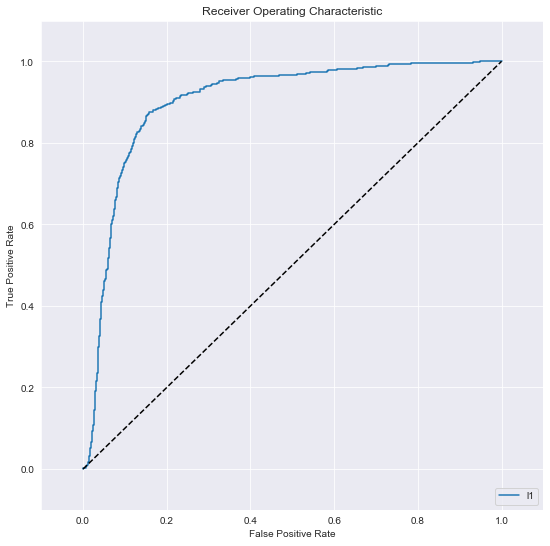

In [228]:
# Initialize figure
fig = plt.figure(figsize=(9,9))
plt.title('Receiver Operating Characteristic')

# Plot ROC curve
plt.plot(fpr, tpr, label='l1')
plt.legend(loc='lower right')

# Diagonal 45 degree line
plt.plot([0,1],[0,1],'k--')

# Axes limits and labels
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<strong style="color:RoyalBlue">Expected output:</strong>
<img src="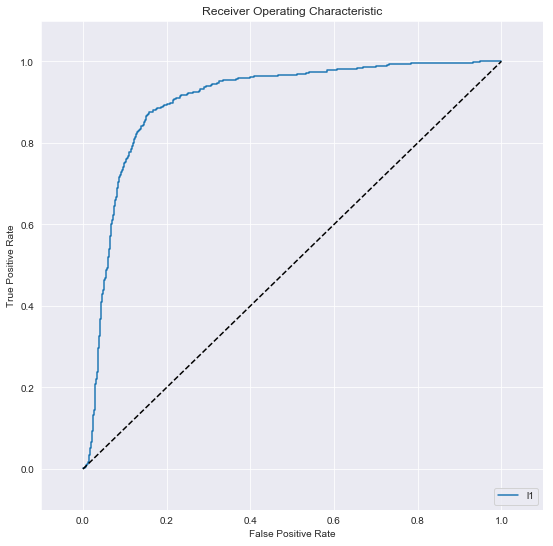&#10;">

#### G.) Finally, answer this question: What is the probability that a randomly chosen <code style="color:crimson">'Left'</code> observation ranks higher (has a higher predicted probability) than a randomly chosen <code style="color:crimson">'Employed'</code> observation?

In [229]:
roc_auc_score(y_test, l1_pred_proba)

0.9015416134300049

<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
0.9015388373737675
</pre>

## <span style="color:RoyalBlue">Exercise 4.6 - Pick the Winner</span>

Now that we've taken a detour to dive into some of the intuition behind AUROC, let's calculate it for each of our fitted models on the test set.

#### A.) Using a <code style="color:SteelBlue">for</code> loop, print the AUROC performance of each model in <code style="color:SteelBlue">fitted_models</code> on the test set.
* Label the output with the name of the algorithm. For example:

<pre style="color:crimson">
rf 0.9915201892159932
</pre>

* Which model had the highest test AUROC?
* Did it also have the highest cross-validated score?

In [230]:
for name, model in fitted_models.items():
    pred_proba = fitted_models[name].predict_proba(X_test)
    pred_proba = [p[1] for p in pred_proba]
    
    print(name, roc_auc_score(y_test, pred_proba))

l1 0.9015416134300049
l2 0.9015381433597084
rf 0.9915194952019338
gb 0.9886802836851869


<strong style="color:RoyalBlue">Expected output:</strong>
<pre>
l1 0.9015388373737675
l2 0.9015367553315894
rf 0.9915201892159932
gb 0.9886802836851869
</pre>

In [231]:
from sklearn.model_selection import cross_val_score

for name, model in fitted_models.items(): 
    print(name, cross_val_score(model, X_test, y_test, cv=10))

l1 [0.85460993 0.81560284 0.84751773 0.88297872 0.87544484 0.81494662
 0.88256228 0.85053381 0.88967972 0.88256228]
l2 [0.84397163 0.81205674 0.84751773 0.88297872 0.87544484 0.81494662
 0.88256228 0.85053381 0.88967972 0.88256228]


KeyboardInterrupt: 

Let's save the winning model. Make sure you've already imported the <code style="color:steelblue">pickle</code> package.

#### B.) Finally, save the winning <code style="color:steelblue">Pipeline</code> object into a pickle file.
* Just save the <code style="color:steelblue">Pipeline</code>, not the <code style="color:steelblue">GridSearchCV</code> object.
* **Hint:** Remember the <code style="color:steelblue">.best\_estimator_</code> attribute?

In [232]:
# best model is the rf model
best_rf_pipeline = fitted_models['rf'].best_estimator_

with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(fitted_models['rf'].best_estimator_, f)
    
print(best_rf_pipeline)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=0.33,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=Fals

Congratulations for making through this model training and evaluation module! As a reminder, here are a few things you did in this module:
* You split your dataset into training and test sets.
* You set up model pipelines and hyperparameter grids.
* You tuned your models using cross-validation.
* You learned about how AUROC is a more effective metric for classification than simple accuracy.
* And finally, you saved the winning model.

In the next module, we'll see how you can go the extra mile in terms of project delivery. That includes preparing to apply your model to raw data and packaging it up into an executable script.